This notebook will train an XGBoost regression model to predict dam fullness
you may not need to run this if you already have the model from the repo

In [1]:
from datetime import datetime
import pickle
import json
import glob
import os

from sklearn.metrics import mean_absolute_error, mean_tweedie_deviance
from xgboost import XGBRegressor
from bayes_opt import BayesianOptimization
import xgboost
import seaborn as sns; sns.set_theme(color_codes=True)
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

In [2]:
# path to training and validation data
training_data_path = os.path.join(os.getcwd(),'data/dam forecast train.csv')

val_data_path = os.path.join(os.getcwd(),'data/dam forecast val.csv')

In [3]:
# set location to save model
model_folder = os.getcwd()
model_name = 'dam_forecast_11-10-22.pkl'
model_path = os.path.join(model_folder,'data',model_name)
model_path

'/home/nick/Documents/Work code/Dam-Forecast/data/dam_forecast_11-10-22.pkl'

In [4]:
# we limit the max dam size as large dams are note well represented in our dataset 
max_value = 20000

In [5]:
# load up training data, do some cleaning/sorting
training_data = pd.read_csv(training_data_path)
training_data = training_data.reindex(sorted(training_data.columns), axis=1)
training_data = (training_data[training_data['dam_area'] < max_value])
training_data.replace([np.inf, -np.inf], 0, inplace=True)
training_data.head()

,SRC_DATE,acq_date_dec,acq_month,acq_year,class,class_name,dam_area,file_name,geometry,rain_0_months before,...,tavg_1_months before,tavg_2_months before,tavg_3_months before,tavg_4_months before,tavg_5_months before,tavg_6_months before,tavg_7_months before,tavg_8_months before,tavg_9_months before,water_area
0,20191216,2019.923077,12,2019,2,no water,1499.986376,arcgisonline_13466_pred_and_score.tif,POINT (150.7703260923624 -34.49997476956882),2.762451,...,20.396746,17.926054,15.415278,12.961130,13.086934,13.189901,16.016296,18.968658,21.853695,0.000000
1,20191216,2019.923077,12,2019,2,no water,1957.925202,arcgisonline_19956_pred_and_score.tif,POINT (150.7609417292462 -34.5194085769909),3.197464,...,20.336300,17.855085,15.332343,12.882524,13.011043,13.112334,15.936459,18.891691,21.774044,0.000000
2,20191216,2019.923077,12,2019,2,no water,56.557682,arcgisonline_29686_pred_and_score.tif,POINT (150.7921407085229 -34.48640159069117),2.658848,...,20.390297,17.952702,15.478308,13.054444,13.186954,13.291353,16.112299,19.028639,21.890549,0.000000
3,20191216,2019.923077,12,2019,0,dam and water,620.839041,arcgisonline_2208_pred_and_score.tif,POINT (150.8273026231211 -34.59007854166663),4.103868,...,19.747135,17.428568,15.065031,12.862777,13.064048,13.170877,15.932156,18.648500,21.329342,69.919793
4,20191216,2019.923077,12,2019,0,dam and water,911.591665,arcgisonline_43254_pred_and_score.tif,POINT (150.8025877887565 -34.57963568981891),3.889048,...,20.026794,17.639698,15.219195,12.937696,13.106893,13.211027,16.005402,18.805094,21.575476,85.853539


In [6]:
# load up validation data and do some cleaning/sorting
val_data = pd.read_csv(val_data_path)
val_data = val_data.reindex(sorted(val_data.columns), axis=1)
val_data = (val_data[val_data['dam_area'] < max_value])
val_data.replace([np.inf, -np.inf], 0, inplace=True)
val_data.head()

,SRC_DATE,acq_date_dec,acq_month,acq_year,class,class_name,dam_area,file_name,geometry,rain_0_months before,...,tavg_1_months before,tavg_2_months before,tavg_3_months before,tavg_4_months before,tavg_5_months before,tavg_6_months before,tavg_7_months before,tavg_8_months before,tavg_9_months before,water_area
0,20151012,2015.769231,10,2015,0,dam and water,1467.191148,arcgisonline_132898_pred_and_score.tif,POINT (117.3172965191077 -33.24564247144878),9.043823,...,12.835136,11.108263,10.531229,12.044368,12.067635,16.236391,20.395378,24.588543,23.805340,400.256079
1,20160808,2016.615385,8,2016,0,dam and water,7575.018970,arcgisonline_70618_pred_and_score.tif,POINT (152.9625759629707 -26.43549796464562),30.879414,...,16.208225,16.421938,19.850100,22.161938,24.166159,25.166771,24.075779,23.361519,23.210749,5781.220903
2,20150329,2015.230769,3,2015,0,dam and water,2028.126533,arcgisonline_84979_pred_and_score.tif,POINT (142.9804044837108 -37.77391478774938),22.954985,...,20.310444,18.668152,16.997301,15.661266,13.949310,11.053338,8.662997,8.203583,9.625609,581.212166
3,20151215,2015.923077,12,2015,0,dam and water,569.161178,arcgisonline_101081_pred_and_score.tif,POINT (145.618767566165 -38.4325091507143),37.716213,...,15.805417,15.925524,11.613432,9.590775,9.022965,10.216203,12.452333,14.021166,16.439243,317.463008
4,20160416,2016.307692,4,2016,0,dam and water,3367.296500,arcgisonline_125002_pred_and_score.tif,POINT (118.0078021793126 -30.57147183423009),31.052204,...,24.274788,26.393480,26.532434,24.433882,23.749607,21.477095,14.928035,12.299461,11.371953,508.559500


In [7]:
training_data.shape

(108847, 36)

In [8]:
val_data.shape

(12092, 36)

In [9]:
# set a list of columns to drop, the model will not see these
drop_list = ['water_area','file_name', 'SRC_DATE','geometry','acq_year','acq_month','acq_date_dec','class','class_name']

In [10]:
# remove the drop list and setup target df
train_X = training_data.drop(columns=drop_list)
train_y = training_data[['water_area']]
print(train_y.head())
train_X.head()

   water_area
0    0.000000
1    0.000000
2    0.000000
3   69.919793
4   85.853539


,dam_area,rain_0_months before,rain_10_months before,rain_11_months before,rain_12_months before,rain_1_months before,rain_2_months before,rain_3_months before,rain_4_months before,rain_5_months before,...,tavg_12_months before,tavg_1_months before,tavg_2_months before,tavg_3_months before,tavg_4_months before,tavg_5_months before,tavg_6_months before,tavg_7_months before,tavg_8_months before,tavg_9_months before
0,1499.986376,2.762451,36.125671,71.728584,69.268257,18.543798,32.006516,61.439262,35.894455,16.539648,...,22.234226,20.396746,17.926054,15.415278,12.961130,13.086934,13.189901,16.016296,18.968658,21.853695
1,1957.925202,3.197464,38.361225,75.389587,73.195740,19.394297,34.531719,64.828262,38.369305,17.053242,...,22.165726,20.336300,17.855085,15.332343,12.882524,13.011043,13.112334,15.936459,18.891691,21.774044
2,56.557682,2.658848,35.916077,69.969917,66.735779,18.249218,31.475410,60.696507,35.672646,16.840359,...,22.226084,20.390297,17.952702,15.478308,13.054444,13.186954,13.291353,16.112299,19.028639,21.890549
3,620.839041,4.103868,46.451984,76.181908,72.046654,19.497202,38.455097,70.509048,42.860733,19.531702,...,21.477997,19.747135,17.428568,15.065031,12.862777,13.064048,13.170877,15.932156,18.648500,21.329342
4,911.591665,3.889048,44.183247,76.219666,72.164078,19.490854,37.583042,69.094116,42.032280,18.774553,...,21.803089,20.026794,17.639698,15.219195,12.937696,13.106893,13.211027,16.005402,18.805094,21.575476


In [11]:
# setup validation sets
val_X = val_data.drop(columns=drop_list)
val_y = val_data[['water_area']].copy()
print(train_y.head())
print(train_X.shape)
train_X.head()

   water_area
0    0.000000
1    0.000000
2    0.000000
3   69.919793
4   85.853539
(108847, 27)


,dam_area,rain_0_months before,rain_10_months before,rain_11_months before,rain_12_months before,rain_1_months before,rain_2_months before,rain_3_months before,rain_4_months before,rain_5_months before,...,tavg_12_months before,tavg_1_months before,tavg_2_months before,tavg_3_months before,tavg_4_months before,tavg_5_months before,tavg_6_months before,tavg_7_months before,tavg_8_months before,tavg_9_months before
0,1499.986376,2.762451,36.125671,71.728584,69.268257,18.543798,32.006516,61.439262,35.894455,16.539648,...,22.234226,20.396746,17.926054,15.415278,12.961130,13.086934,13.189901,16.016296,18.968658,21.853695
1,1957.925202,3.197464,38.361225,75.389587,73.195740,19.394297,34.531719,64.828262,38.369305,17.053242,...,22.165726,20.336300,17.855085,15.332343,12.882524,13.011043,13.112334,15.936459,18.891691,21.774044
2,56.557682,2.658848,35.916077,69.969917,66.735779,18.249218,31.475410,60.696507,35.672646,16.840359,...,22.226084,20.390297,17.952702,15.478308,13.054444,13.186954,13.291353,16.112299,19.028639,21.890549
3,620.839041,4.103868,46.451984,76.181908,72.046654,19.497202,38.455097,70.509048,42.860733,19.531702,...,21.477997,19.747135,17.428568,15.065031,12.862777,13.064048,13.170877,15.932156,18.648500,21.329342
4,911.591665,3.889048,44.183247,76.219666,72.164078,19.490854,37.583042,69.094116,42.032280,18.774553,...,21.803089,20.026794,17.639698,15.219195,12.937696,13.106893,13.211027,16.005402,18.805094,21.575476


In [12]:
# save out metadata to json, this is usefull when running predictions
meta_dict = {'col_names':list(train_X.columns),
            'model_path':model_path,
            'creation_date':str(datetime.today().strftime('%Y-%m-%d'))}

with open(model_path.replace('.pkl','.json'), 'w') as fp:
    json.dump(meta_dict, fp)

In [13]:
train_X.sample(frac=.8)

,dam_area,rain_0_months before,rain_10_months before,rain_11_months before,rain_12_months before,rain_1_months before,rain_2_months before,rain_3_months before,rain_4_months before,rain_5_months before,...,tavg_12_months before,tavg_1_months before,tavg_2_months before,tavg_3_months before,tavg_4_months before,tavg_5_months before,tavg_6_months before,tavg_7_months before,tavg_8_months before,tavg_9_months before
18615,2376.655687,66.215576,88.440361,36.141411,60.573677,78.685822,150.398804,101.764862,128.267731,110.825584,...,16.805124,10.643298,9.609923,7.600095,7.432047,6.941716,10.659147,15.084528,20.069304,20.434866
14913,657.451138,63.112328,104.019905,53.489861,101.113472,129.750107,198.719315,125.810143,177.548752,126.781685,...,19.228615,12.458045,11.410372,8.945420,8.485148,8.731163,12.011193,16.601084,21.817421,22.768276
47819,1351.384216,40.937527,47.779690,52.641098,27.910006,11.032359,41.911167,37.274918,41.581894,21.184118,...,15.733973,19.680912,20.147791,20.204020,16.074198,16.655382,10.226814,7.797535,6.871313,8.056233
94957,4873.558772,195.539505,17.528772,7.131042,74.969940,57.919518,4.710438,40.120667,48.424007,3.631379,...,24.750265,25.882427,22.192951,17.759228,15.400226,13.212238,15.728498,17.794487,21.817310,24.939156
97796,3841.863347,13.480301,24.218273,10.159765,61.618202,4.451368,16.288559,50.212616,9.637210,17.842812,...,24.744976,23.270927,17.155241,13.563071,11.171509,13.369135,17.030703,21.691814,25.184935,27.630579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48751,2217.562462,77.330894,28.573290,46.783356,20.634510,2.104004,140.205917,31.927446,13.907731,18.559982,...,20.315481,22.407570,23.087519,20.787285,19.874931,18.139549,12.811227,11.217198,10.800653,12.146920
24456,16156.712629,19.521051,98.943352,73.708008,43.086712,124.156151,38.472881,65.636993,67.674011,6.555453,...,22.854332,18.339050,14.686425,14.436732,14.942582,18.881399,23.421743,26.832750,26.890469,27.282705
74751,907.018654,5.646827,30.672750,38.886791,12.642448,2.106509,44.636475,8.224180,18.741484,4.391818,...,18.914597,23.073044,21.225948,19.481112,18.363571,16.750772,13.224217,9.529796,9.761949,11.024407
82428,1105.176917,48.455772,65.556549,32.823391,4.999503,61.327671,20.906189,48.593174,22.942192,27.279732,...,20.442993,19.010099,17.671961,16.160791,14.373621,11.742456,9.153528,8.588122,10.116889,12.791488


In [14]:
model_path

'/home/nick/Documents/Work code/Dam-Forecast/data/dam_forecast_11-10-22.pkl'

In [15]:
# func to train a model using variable inputs
def train_model(learning_rate,n_estimators,max_depth):

    n_estimators = round(n_estimators)
    max_depth = round(max_depth)
    
    xgb_reg = XGBRegressor(learning_rate = learning_rate, 
                               n_estimators = n_estimators,
                               max_depth=max_depth,
                               tree_method='hist',
                               objective='reg:tweedie',
                              )
    xgb_reg.fit(train_X, train_y,verbose = 0)

    y_pred = xgb_reg.predict(val_X)
    y_pred = y_pred*(y_pred>0)
    
    model_mean_error = mean_absolute_error(val_data['water_area'].to_numpy(), y_pred)
                
    return(-model_mean_error)

In [16]:
# set the bounds for optimization search
pbounds = {'learning_rate': (0.1, 0.5), 'n_estimators': (10, 700),'max_depth': (1,15)}

In [17]:
# setup optimizer
optimizer = BayesianOptimization(
    f=train_model,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

In [18]:
# run optimizer
optimizer.maximize(
    init_points=15,
    n_iter=30,
)

|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
|  1        | -948.8    |  0.2668   |  11.08    |  10.08    |
|  2        | -357.2    |  0.2209   |  3.055    |  73.71    |
|  3        | -332.8    |  0.1745   |  5.838    |  283.8    |
|  4        | -360.6    |  0.3155   |  6.869    |  482.8    |
|  5        | -459.7    |  0.1818   |  13.29    |  28.9     |
|  6        | -358.0    |  0.3682   |  6.842    |  395.5    |
|  7        | -331.9    |  0.1562   |  3.773    |  562.5    |
|  8        | -350.4    |  0.4873   |  5.388    |  487.7    |
|  9        | -416.2    |  0.4506   |  13.52    |  68.68    |
|  10       | -338.0    |  0.1156   |  3.378    |  615.9    |
|  11       | -341.5    |  0.1393   |  6.896    |  670.9    |
|  12       | -392.3    |  0.3133   |  10.69    |  227.7    |
|  13       | -378.7    |  0.3746   |  12.68    |  22.62    |
|  14       | -448.5    |  0.4001   |  14.84    |  526.2    |
|  15   

In [37]:
# show best vars
# best_pers = optimizer.max
# best_pers

In [30]:
def train_fin_model(learning_rate,n_estimators,max_depth):

    n_estimators = round(n_estimators)
    max_depth = round(max_depth)
    xgb_reg = XGBRegressor(learning_rate = learning_rate, 
                               n_estimators = n_estimators,
                               max_depth=max_depth,                        
                               tree_method='hist',
                               objective='reg:tweedie',
                              )
    xgb_reg.fit(train_X, train_y, eval_set=[(train_X, train_y)],verbose = 0)
    
    return(xgb_reg)

In [31]:
model_count = 10

In [32]:
top_5_models = pd.DataFrame(optimizer.res).sort_values('target', ascending=[False]).head(model_count)
top_5_models

,target,params
6,-331.928987,"{'learning_rate': 0.15615477543809353, 'max_de..."
2,-332.836998,"{'learning_rate': 0.17450408455106836, 'max_de..."
23,-337.833877,"{'learning_rate': 0.1764501799639149, 'max_dep..."
9,-338.042929,"{'learning_rate': 0.11562191329315295, 'max_de..."
10,-341.524034,"{'learning_rate': 0.13933873353322004, 'max_de..."
21,-341.569455,"{'learning_rate': 0.4469655272896925, 'max_dep..."
25,-343.581690,"{'learning_rate': 0.2423859410906903, 'max_dep..."
26,-343.722541,"{'learning_rate': 0.22444419755490622, 'max_de..."
7,-350.381651,"{'learning_rate': 0.48730463028775906, 'max_de..."
1,-357.151229,"{'learning_rate': 0.22093302905273593, 'max_de..."


In [33]:
models = []
for row, model_hyps in tqdm(top_5_models.iterrows(),total=model_count):
    models.append({'model_number':str(row),
                   'model':train_fin_model(**model_hyps['params'])})

  0%|          | 0/10 [00:00<?, ?it/s]

In [34]:
preds = pd.DataFrame()
for model in models:
    y_pred = model['model'].predict(val_X)
    y_pred = y_pred*(y_pred>0)
    preds[model['model_number']] = y_pred
    

In [35]:
preds

,6,2,23,9,10,21,25,26,7,1
0,266.933197,305.601929,294.259216,305.285156,272.463928,271.721405,308.411316,298.183075,283.471039,343.662201
1,3960.975098,4072.361572,3981.680420,4073.526855,4328.954102,3684.588135,4453.635254,3939.295166,4508.527344,5149.312500
2,455.189240,472.240479,456.022156,486.332245,419.583984,625.575256,611.636536,599.865601,413.812531,610.697266
3,223.655014,209.576721,220.012192,228.856567,219.733521,211.523438,219.630859,237.618484,237.145905,220.911530
4,891.838745,792.803406,963.269470,983.724121,842.511475,971.994995,975.909546,950.533325,1012.423889,873.592468
...,...,...,...,...,...,...,...,...,...,...
12087,4124.213867,3633.010254,3865.309814,3966.724854,4089.614502,4142.049805,4170.143555,4018.193848,3392.324219,4011.891357
12088,208.115906,223.158691,228.745285,201.896454,221.872940,204.673569,184.323425,186.883148,233.330307,225.186035
12089,1451.146118,1219.943359,2064.475098,1502.062988,1209.177734,1392.458618,1427.393188,1512.642334,1678.557617,1424.146851
12090,1271.824341,1188.393921,1283.830811,1360.747925,1151.128662,1158.511353,1201.650879,1175.020386,1468.473633,1023.174683


In [36]:
val_y['preds'] = preds.mean(axis=1).to_list()

In [37]:
val_y

,water_area,preds
0,400.256079,294.999237
1,5781.220903,4215.286133
2,581.212166,515.095520
3,317.463008,222.866425
4,508.559500,925.860229
...,...,...
12230,5955.113008,3941.347656
12231,106.330725,211.818604
12232,2320.997848,1488.200439
12233,1341.055972,1228.275635


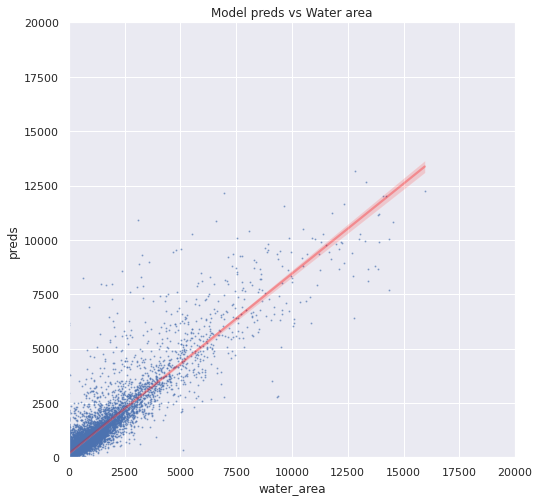

In [38]:
# plot up validation data preds vs measured values
ax = sns.regplot(x="water_area", y="preds", data=val_y,
                 scatter_kws={'s':1, 'alpha':0.5},
                 line_kws={"color": "red",'alpha':0.3}
                )
sns.set(rc={"figure.figsize":(8, 8)})
ax.set(ylim=(0, max_value))
ax.set(xlim=(0, max_value))
ax.set(title='Model preds vs Water area');

In [39]:
# use numpy to calc the line of best fit equation
# note this this looks much better than the scaled factor above
grad, y_intersect = np.polyfit(val_y['water_area'], val_y['preds'], 1)
grad, y_intersect

(0.8277198726206255, 167.2521286573701)

In [40]:
# significant improvment from scaled factor above
model_mea = mean_absolute_error(val_y['water_area'], val_y['preds'])
model_mea

330.98817331053294

In [41]:
model_improvment = 1-(model_mea/466.89)
print(f'the model is {round(model_improvment*100)}% better than the scaled dam area') 

the model is 29% better than the scaled dam area


In [42]:
model_improvment = 1-(model_mea/885.85)
print(f'the model is {round(model_improvment*100)}% better than always guessing water area mean') 

the model is 63% better than always guessing water area mean


In [43]:
# save model to disk
# pickle.dump(xgb_reg, open(model_path, "wb"))
pickle.dump(models, open(model_path, "wb"))

In [44]:
model_path

'/home/nick/Documents/Work code/Dam-Forecast/data/dam_forecast_11-10-22.pkl'